In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/Users/nish/Local/Programming/convertkit_wrapper')
from modules.ck_utils import *

session = requests.session()

9/27/19 dgnutils update loaded!


In [2]:
conn, cursor = connect()

### Data Validation and Corrections

#### Get Data

In [5]:
#### THIS WILL COMMIT ####
conn.commit() 

all_rds_list = cursor.e('SELECT * FROM subscriber_data')
all_rds_dict = {a['id']: a for a in all_rds_list}

In [6]:
# ~6 seconds to ~15 seconds
all_ck_list = get_api_data(CK_Api.ALL_SUBS, None, session=session)
all_ck_dict = {a['id']: a for a in all_ck_list}

print(all_rds_list[0].values()); print(); print(all_ck_list[0].values())

dict_values([221, 'cancelled', None, 'dnishiyama+test5@gmail.com', '2019-05-08T18:21:55.000Z', None, None, None, None, None, None, 'Influence Map', 'MCS Page', None, '11:59pm EDT on Wednesday, May 15, 2019', '2019-05-08', '2019-05-08', None, None, None, None])

dict_values([137634069, 'Jessica', 'jgschloss@gmail.com', 'active', '2017-10-03T13:16:28.000Z', None, None, None, None, None, 'MailChimp', 'MailChimp', 'Mountain View', 'United States of America', '37.386', '-122.084', 'California', '2017-05-16 11:43:05', None, None, '2017-05-16', None])


#### Summarize issues

In [7]:
# See if any subscribers are missing from RDS
## Get step function data first
get_id = lambda x: int(re.match(r'.*?_(\d+)', x).group(1))
recent_execution = lambda x: x['stopDate'] > datetime.now().astimezone(pytz.timezone('US/Eastern')) - timedelta(hours=1)
client = boto3.client('stepfunctions')
sub_arn = 'arn:aws:states:us-east-1:787744691769:stateMachine:CK_Subscription'
running_executions = client.list_executions(stateMachineArn=sub_arn, statusFilter='RUNNING')['executions']
success_executions = client.list_executions(stateMachineArn=sub_arn, statusFilter='SUCCEEDED')['executions']
executions = running_executions + [e for e in success_executions if recent_execution(e)]
processing_subs = [get_id(e['name']) for e in executions]; len(processing_subs), processing_subs

ck_subs_not_in_rds = [a for a in all_ck_dict if a not in all_rds_dict and a not in processing_subs]
print(f'CK subs missing from RDS: {len(ck_subs_not_in_rds)}')

# These are probably ok, but are delayed due to delay of gathering ck data
today = datetime.strftime(datetime.now(), '%Y-%m-%d')
rds_subs_not_in_ck = [a for a in all_rds_dict if all_rds_dict[a]['state'] == 'active' and a not in all_ck_dict and all_rds_dict[a]['subscribe_date'] != today]
print(f'RDS subs missing from CK: {len(rds_subs_not_in_ck)}')

print()

# Duplicate emails in RDS
duplicate_rds_emails = [c for c in Counter([a['email_address'] for a in all_rds_list]).items() if c[1]>1]
print(f'Duplicate emails in RDS: {len(duplicate_rds_emails)}')

# Total Mismatches
mismatches = [a for a in all_rds_dict if a in all_ck_dict and array_mismatch(all_rds_dict[a], all_ck_dict[a])]
print(f'Total mismatches: {len(mismatches)}')

print(f'There are {len(set([a["lead_source"] for a in all_rds_list]))} / 10 lead_sources')
print(f'There are {len(set([a["lead_opt-in"] for a in all_rds_list]))} / 14 lead_opt-ins')
# set(a['lead_opt-in'] for a in all_rds_list + all_ck_list)
# set(a['lead_source'] for a in all_rds_list + all_ck_list)

# Mismatch between email_data and email_data_freshness (active subscribers with email_data but no email_data_freshness)
sql_stmt = """\
SELECT s.id FROM email_data e
LEFT JOIN subscriber_data s
    ON s.id = e.subscriber_id
LEFT JOIN email_data_freshness f
    ON f.subscriber_id = e.subscriber_id
WHERE f.subscriber_id IS NULL
    AND s.state = "active"
"""
cursor.execute(sql_stmt)
missing_freshness_ids = [c['id'] for c in cursor.fetchall()]; len(missing_freshness_ids), missing_freshness_ids[:3]
print(f'Missing freshness data: {len(missing_freshness_ids)}')

# Subscribers with no email data
sql_stmt = """\
SELECT s.id FROM subscriber_data s
LEFT JOIN email_data e
    ON e.subscriber_id = s.id
WHERE e.subscriber_id IS NULL
    AND s.state = "active"
"""
cursor.execute(sql_stmt)
no_email_subscribers = [c['id'] for c in cursor.fetchall()]; len(no_email_subscribers), no_email_subscribers[-3:]
print(f'Subscribers with no email data: {len(no_email_subscribers)}')

# Subscriber with no subscribe date
no_subscribe_date_rds = [a['id'] for a in all_rds_list if a['state'] == 'active' and not a['subscribe_date']]
print(f'RDS Subscribers with no subscribe_date: {len(no_subscribe_date_rds)}')

no_subscribe_date_ck = [a['id'] for a in all_ck_list if a['state'] == 'active' and not a['subscribe_date'] and a['id'] not in processing_subs]
print(f'CK Subscribers with no subscribe_date: {len(no_subscribe_date_ck)}')

# active subscriber with an unsubscribe_date (resubscriber)
err_unsub_date = [a['id'] for a in all_rds_list if a['state'] == 'active' and a['unsubscribe_date']]
print(f'Unnecessary unsub dates: {len(err_unsub_date)}')
      
# Missing Location
nones = ['null', None, 0]
missing_loc = [a for a in all_rds_list 
                if (a['loc_country'] in nones or a['loc_lat'] in nones or a['loc_lng'] in nones) 
                and (a['loc_city'] not in nones or a['loc_state'] not in nones)]
print(f'Missing location data: {len(missing_loc)}')
      
# Add things to fix in the future here
print(Counter([a['state'] for a in all_rds_list if not a['subscribe_date'] and a['state']=='complained']))
      #subscribe date needs to be calculated based on mailchimp, or the first email clicked, or the first email sent
print("Are all the purchase values, purchase refunds accurate?")
print("Are all lead opt-ins found based on the first email sent")
print("how many opt-ins has a person done?, this could be from the scraping")


CK subs missing from RDS: 0
RDS subs missing from CK: 0

Duplicate emails in RDS: 0
Total mismatches: 17
There are 12 / 10 lead_sources
There are 15 / 14 lead_opt-ins
Missing freshness data: 0
Subscribers with no email data: 414
RDS Subscribers with no subscribe_date: 4
CK Subscribers with no subscribe_date: 7
Unnecessary unsub dates: 1
Missing location data: 20
Counter({'complained': 10})
Are all the purchase values, purchase refunds accurate?
Are all lead opt-ins found based on the first email sent
how many opt-ins has a person done?, this could be from the scraping


#### Fix Issues

In [ ]:
# TODO: Make this into separate functions that give a summary of the data to be updated 
# they then ask for confirmation depending on if that is sent in as a parameter

In [ ]:
# For doing the basic updates
for sub_id in [501116407, 137664062]:#no_subscribe_date_rds:
    print(update_single_subscriber(
        sub_id, 
        cursor, 
        ck_app_session=get_ck_session(), 
        do_location=True, 
        geolocator=Nominatim(user_agent="dgn")
    ))

In [ ]:
# Continuous updates
# 1st Priority, the updates in one system are made in AWS
# 2nd Priority, I can run one cell which will make the entire system up-to-date

In [ ]:
#### Function to keep entire system up-to-date

### All these can be fixed by bringing the mismatch data from CK to RDS
############ Get the non-actives updated first process ############

try:
    # TODO: Make this async
    update_rds_with_non_actives(cursor, only_new=True)#limit_to_past_days=30)
except:
    print('Error with update_rds_with_non_actives')

############ Get the step_function in process ############
get_id = lambda x: int(re.match(r'.*?_(\d+)', x).group(1))
recent_execution = lambda x: x['stopDate'] > datetime.now().astimezone(pytz.timezone('US/Eastern')) - timedelta(hours=1)
client = boto3.client('stepfunctions')
sub_arn = 'arn:aws:states:us-east-1:787744691769:stateMachine:CK_Subscription'
running_executions = client.list_executions(stateMachineArn=sub_arn, statusFilter='RUNNING')['executions']
success_executions = client.list_executions(stateMachineArn=sub_arn, statusFilter='SUCCEEDED')['executions']
executions = running_executions + [e for e in success_executions if recent_execution(e)]
processing_subs = [get_id(e['name']) for e in executions]; len(processing_subs), processing_subs

############ Get the mismatches ############
mismatches = [a for a in all_rds_dict if a in all_ck_dict and array_mismatch(all_rds_dict[a], all_ck_dict[a])]
print(f'Updating {len(mismatches)} subs with mismatches in RDS...')
for mismatch in mismatches:
    transfer_good_mismatches_to_rds(cursor, session, all_rds_dict[mismatch], all_ck_dict[mismatch])

############ Complained and deleted subscribers show up as "RDS subs missing from CK" ############
today = datetime.strftime(datetime.now(), '%Y-%m-%d')
rds_subs_not_in_ck = [a for a in all_rds_dict if all_rds_dict[a]['state'] == 'active' and a not in all_ck_dict and all_rds_dict[a]['subscribe_date'] != today]
print(f'Updating {len(rds_subs_not_in_ck)} subs in rds_subs_not_in_ck with mismatches in RDS...')
for sub_id in rds_subs_not_in_ck:
    try:
        ck_data = get_single_subscriber(session=session, subscriber_id=sub_id)
        transfer_good_mismatches_to_rds(cursor, session, all_rds_dict[sub_id], ck_data)
    except:
        print(f'Setting state to deleted for sub_id {sub_id}')
        cursor.e(f'UPDATE subscriber_data SET state="deleted" WHERE id={sub_id}')

############ Resubscribers show up as "ck_subs_not_in_rds" ############
## Missed subscribers (maybe an overwrite on the db?) show up as "ck_subs_not_in_rds"
ck_subs_not_in_rds = [a for a in all_ck_dict if a not in all_rds_dict and a not in processing_subs]
print(f'Updating {len(ck_subs_not_in_rds)} subs in ck_subs_not_in_rds into RDS...')
for sub_id in ck_subs_not_in_rds:
    rds_sub = cursor.e(f'SELECT * FROM subscriber_data WHERE id={sub_id}')
    if not rds_sub:
        update_subscriber_in_rds(sub_id, cursor, sub_data=all_ck_dict[sub_id])

############ resubscribers keep their unsub date ############
err_unsub_date = [a['id'] for a in all_rds_list if a['state'] == 'active' and a['unsubscribe_date']]
print(f'Updating {len(err_unsub_date)} subs from err_unsub_date in CK and RDS...')
for sub_id in err_unsub_date:
    update_sub_everywhere_with_misc(sub_id, cursor, session=session, **{'unsubscribe_date': None})

############ Missing rds subscribe_date ############
no_subscribe_date_rds = [a['id'] for a in all_rds_list if a['state'] == 'active' and not a['subscribe_date']]
no_subscribe_date_ck = [a['id'] for a in all_ck_list if a['state'] == 'active' and not a['subscribe_date'] and a['id'] not in processing_subs]
print(f'Updating {len(no_subscribe_date_rds + no_subscribe_date_ck)} subs with no subscribe_date in CK and RDS...')
for sub_id in no_subscribe_date_rds + no_subscribe_date_ck:
    update_single_subscriber(sub_id, cursor, ck_app_session=get_ck_session(), geolocator=Nominatim(user_agent='dgn_app'))
    
############ Manage the duplicate emails in the right way ############
# Get all the duplicated emails
duplicate_rds_emails = [c[0] for c in Counter([a['email_address'] for a in all_rds_list]).items() if c[1]>1]

# Get the data for those emails
duplicate_rds_subs = {} 
for a in all_rds_list:
    if a['email_address'] not in duplicate_rds_emails: continue
    duplicate_rds_subs.setdefault(a['email_address'], []).append({b:a[b] for b in ['id', 'state']}) 

remove_ids = [] # Add the lists of [[id_to_use1, id_to_remove1], [id_to_use2, id_to_remove2], ...]

for (email, subs) in duplicate_rds_subs.items():
    if len(subs) != 2: raise Exception(f'There were {len(subs)} subs for this duplicate. Need to handle this')
        
    # If either is deleted, then remove the lowered number deleted item 
    # could be 0,1, or 2 ids; reversed to organize with largest first
    deleted_subs = sorted([s['id'] for s in subs if s['state'] == 'deleted'], reverse=True) 
    if deleted_subs: 
        # Now add the non deleted ones to the front (since they won't be removed)
        remove_ids.append([s['id'] for s in subs if s['state'] != 'deleted'] + deleted_subs)
        continue
    
    # If either is a low sub_id (<1,000,000) then remove the lowered numbered one
    low_id_subs = sorted([s['id'] for s in subs if s['id'] < 1000000], reverse=True) 
    if low_id_subs: 
        # Now add the high id ones to the front (since they won't be removed)
        remove_ids.append([s['id'] for s in subs if s['id'] >= 1000000] + low_id_subs)
        continue
        
    # If either is deleted but state is wrong
    # This will find the id if it exists, if not then both are deleted, only keep the 
    temp_id = get_single_subscriber(session=session, email_address=email, cancelled=True).get('id', None)
    if temp_id:
        remove_ids.append([temp_id]+[s['id'] for s in subs if s['id'] != temp_id])
        continue

    print(f'Found no error for {email}, {subs}')
    
# When removing, make sure all the other databases are updated
print(f'Updating RDS for {len(remove_ids)} removal of duplicates...')
temp = cursor.executemany(f'UPDATE launch_data SET subscriber_id=%s WHERE subscriber_id=%s', remove_ids)
print(f'Changed {temp} items in launch_data...')
temp = cursor.executemany(f'UPDATE purchase_data SET subscriber_id=%s WHERE subscriber_id=%s', remove_ids)
print(f'Changed {temp} items in purchase_data...')
temp = cursor.executemany(f'UPDATE purchase_data SET purchaser_id=%s WHERE purchaser_id=%s', remove_ids)
print(f'Changed {temp} items in purchase_data...')
temp = cursor.e(f'DELETE FROM subscriber_data WHERE id IN {mysql_array([r[1] for r in remove_ids])}')
print(f'Deleted {temp} items in subscriber_data...')

############ Fix bad lead sources and lead opt-ins ############

# Fix lead source by going to each with that CK data and updating, then updating the rds data
conversions = [
    ['', 'Unknown'],
    [None, 'Unknown'],
    ['None', 'Unknown'],
    ['FB Ad?fbclid', 'FB Ad'], 
    ['FB+Ad', 'FB Ad'],
    ['Medium?source', 'Medium'],
    ['style mini-course', 'Style Mini-course'],
    ['emails', 'Emails'],
    ['Mailchimp', 'MailChimp'],
]
err_leads = [c[0] for c in conversions]

bad_subs = set()
bad_subs |= set(a['id'] for a in all_rds_list if a['lead_source'] in err_leads or a['lead_opt-in'] in err_leads)
bad_subs |= set(a['id'] for a in all_ck_list if a['lead_source'] in err_leads or a['lead_opt-in'] in err_leads)

print(f'{len(bad_subs)} to update')

for i, a in enumerate([all_ck_dict.get(b, all_rds_dict.get(b, {})) for b in bad_subs]):
    new_data = {}
    for lead in ['lead_source', 'lead_opt-in']:
        if a[lead] in [c[0] for c in conversions]: 
            new_data[lead] = [c[1] for c in conversions if c[0] == a[lead]][0]

    if not new_data: raise Exception()
    print(f'Updating {a["id"]} with {new_data} vs src:{a["lead_source"]}, opt:{a["lead_opt-in"]}', end='\r')

    update_sub_everywhere_with_misc(a['id'], cursor, session=session, **new_data)
          
############ Fix bad locations (lat, lng, country) ############
print(f'Updating CK & RDS for {len(missing_loc)} missing locations...')
          
nones = ['null', None, 0]
missing_loc = [a for a in all_rds_list 
                if (a['loc_country'] in nones or a['loc_lat'] in nones or a['loc_lng'] in nones) 
                and (a['loc_city'] not in nones or a['loc_state'] not in nones)]

          
for sub_data in missing_loc:
    updates = {}
    # Missing lat, lng
    if sub_data['loc_lat'] in nones or sub_data['loc_lng'] in nones:
        latlng = get_lat_and_lng(sub_data['loc_city'], sub_data['loc_state'], Nominatim(user_agent='dgn'))
        sub_data['loc_lat'] = latlng['lat']; updates['loc_lat'] = latlng['lat']
        sub_data['loc_lng'] = latlng['lng']; updates['loc_lng'] = latlng['lng']
        
    if sub_data['loc_country'] in nones:
        coord = ( float(sub_data['loc_lat']), float(sub_data['loc_lng']) )
        sub_data['loc_country'] = iso3166.countries_by_alpha2.get(rg.search(coord, mode=1)[0]['cc'], None).name
        updates['loc_country'] = sub_data['loc_country']
    
    update_sub_everywhere_with_misc(sub_data['id'], cursor, session, **updates)

############ Scrape all the email data ############
scrape_all_email_data(conn, exclude_freshness=2, connections=20)
          
#update_subscriber_in_rds(a['id'], cursor, sub_data={**a, **new_data}) # If item is deleted then only update rds

In [ ]:
scrape_all_email_data(conn, exclude_freshness=2, connections=20)

In [ ]:
conn.commit()

#### Get inactive data

In [ ]:
results = trio.run(get_api_data_async())

In [51]:
get_single_subscriber(session=session, subscriber_id=597074949)

{'id': 597074949,
 'first_name': None,
 'email_address': 'llambert953@gmail.com',
 'state': 'inactive',
 'created_at': '2019-09-28T01:59:06.000Z',
 'fb_ad': None,
 'fb_ad_set': None,
 'fb_audience_source': None,
 'fb_campaign': None,
 'last_name': None,
 'lead_opt-in': 'MCDT',
 'lead_source': 'FB Ad',
 'loc_city': None,
 'loc_country': None,
 'loc_lat': None,
 'loc_lng': None,
 'loc_state': None,
 'mailchimp_sub_date': None,
 'other_email_address': None,
 'stsbc_evg_launch_deadline': None,
 'subscribe_date': None,
 'unsubscribe_date': None}

In [50]:
list({k:v for k,v in all_rds_dict.items() if v['state']=='inactive'}.items())[-1]

(597074949,
 {'id': 597074949,
  'state': 'inactive',
  'first_name': '',
  'email_address': 'llambert953@gmail.com',
  'created_at': '2019-09-27T21:59:00.000Z',
  'fb_audience_source': None,
  'loc_city': None,
  'loc_state': None,
  'loc_country': None,
  'loc_lat': None,
  'loc_lng': None,
  'lead_opt-in': None,
  'lead_source': None,
  'mailchimp_sub_date': None,
  'stsbc_evg_launch_deadline': None,
  'subscribe_date': None,
  'unsubscribe_date': None,
  'other_email_address': None,
  'fb_ad': None,
  'fb_ad_set': None,
  'fb_campaign': None})

#### Adding 

### Analysis

#### Launch information

In [ ]:
purchases, launches = get_detailed_purchase_and_launch_data(cursor)

In [ ]:
print(ck_sub_data)

In [ ]:
attrs = {}
# attrs['country'] = ['United States of America', 'Canada']
# attrs['lead_opt-in'] = ['Influence Map', 'Style Mini-course']
# attrs['lead_opt-in'] = 'Influence Map'
# attrs['lead_source'] = 'FB Ad'
# attrs['lead_opt-in'] = 'Style Mini-course'
attrs['lead_opt-in'] = 'Emails'
attrs['launch'] = 'Launch_6'
# attrs['launch'] = 'Evergreen_2'
_all = True

p, l = specific_purchase_rate(purchases, launches, **attrs)
try:
    print(f'purchase rate is {len(p)}/{len(l)} {round(len(p)/len(l)*100,2)}%')
except ZeroDivisionError as z:
    print(f'There were no launches that fit this criteria {attrs}')


In [ ]:
# Other to evaluate
# What is the likelihood that they will buy based on the number of emails they have received? That they have opened?
# % based on duration on the list?

In [ ]:
conn

In [ ]:
import dgnutils
dgnutils.__file__

#### Subscriber Quality

##### Using it

In [ ]:
# i want to look at a cohort of people, and see how their average metric (open rate, etc) changed over time

In [3]:
all_rds_dict, launch_info_dict, launch_dict, purchase_dict, emails_dict = get_mysql_dicts(cursor)

In [44]:
# 10s for 1000 people; 70s for 10k
cohort = {
    k:v 
    for k,v in all_rds_dict.items() 
        if v['lead_opt-in']=="MCDT" 
#         and v['lead_source']=="FB Ad"
}; len(cohort)
# cohort = {k:v for k,v in all_rds_dict.items() if k%1000==0}; len(cohort)
# cohort = {564316817: all_rds_dict[564316817]}; len(cohort)
    
day_metrics = {}
min_group = 5 # Minimum number to do an analysis for
sorted_unsubs_desc = sorted([time_ck_to_dt(c['subscribe_date']) for c in cohort.values() if c['subscribe_date']], reverse=True)
longest_subscription = (datetime.today() - sorted_unsubs_desc[-min_group]).days #~5th last unsub date

for i, (sub_id, sub_data) in enumerate(cohort.items()):
    if i % 50 == 0 or i == len(cohort) - 1: print(f'Progress {i+1}/{len(cohort)}', end='\r')
    
    if not sub_data['subscribe_date']: continue
        
    sub_emails = emails_dict.get(sub_id, [])
    if not sub_emails: continue
        
    start_date = time_ck_to_dt(sub_data['subscribe_date']) if sub_data['subscribe_date'] else time_created_to_dt(sub_data['created_at'])
    end_date = time_ck_to_dt(sub_data['unsubscribe_date']) if sub_data['unsubscribe_date'] else datetime.today()
    days = (end_date - start_date).days
    subscribe_dt = time_ck_to_dt(sub_data['subscribe_date']) if sub_data['subscribe_date'] else None
    unsubscribe_dt = time_ck_to_dt(sub_data['unsubscribe_date'] or '9999-12-31')
    created_dt = time_created_to_dt(sub_data['created_at'])
    
    metrics = {}
    for d in range(longest_subscription): # 0 to ~1100 
        metrics = {'sub_id': sub_id}
        metrics['subscribed'] = unsubscribe_dt > subscribe_dt + timedelta(days = d)
        metrics['activated'] = subscribe_dt < created_dt + timedelta(days = d)
        
        if d < days: # If the day is after this sub's tenure        
            metrics['open'] = get_rate(
                sub_emails, 
                act_before = subscribe_dt + timedelta(days = d),
                del_before = subscribe_dt + timedelta(days = d-1),
                _open=True,
            )
            metrics['click'] = get_rate(
                sub_emails, 
                act_before = subscribe_dt + timedelta(days = d),
                del_before = subscribe_dt + timedelta(days = d-1),
                _open=False,
            )

            if 'open' in metrics and not metrics['open']: del metrics['open']
            if 'click' in metrics and not metrics['click']: del metrics['click']
                
        # Do this regardless of the day situation
        if len(metrics) > 1: day_metrics.setdefault(d, []).append(metrics)

metric_cols = ['open', 'click', 'activated', 'subscribed']
# { 356: [{'open': 0.06, 'click': 0.06, 'sub_id': 137633000}, {'open': 0.05, 'click': 0.01, 'sub_id': 179295000}] }
x,*y = zip( 
    *sorted( 
        [
            [
                day, 
                *[
                    sum([vi[m] for vi in v if m in vi]) / \
                    len([vi[m] for vi in v if m in vi]) 
                        if len([vi[m] for vi in v if m in vi]) > min_group else None
                    for m in metric_cols 
                ]
            ] 
            for day, v in day_metrics.items() 
        ]
    )
)

# Troubleshooting
# for day, v in day_metrics.items():
#     for m in metric_cols:
#         sum([vi[m] for vi in v if m in vi])/len([vi[m] for vi in v if m in vi])

(0, 50)

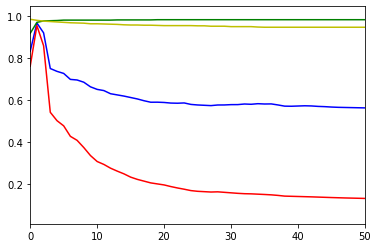

In [45]:
plt.plot(x,y[0],'b', x,y[1],'r', x,y[2],'g', x,y[3],'y')
axes = plt.gca()
# axes.set_ylim([0,1])
axes.set_xlim([0,50])

(0, 750)

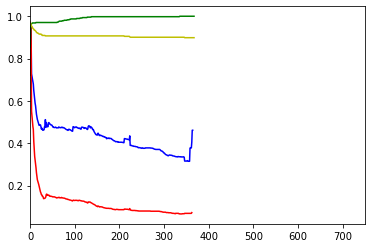

In [36]:
plt.plot(x,y[0],'b', x,y[1],'r', x,y[2],'g', x,y[3],'y')
axes = plt.gca()
# axes.set_ylim([0,1])
axes.set_xlim([0,750])

In [ ]:
# Influence Map FB Ad
plt.plot(x,y[0], 'b', x, y[1], 'b')
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,750])

In [ ]:
# MCDT FB Ad
plt.plot(x,y[0], x, y[1])
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,750])

In [ ]:
# MCDT
plt.plot(x,y[0], x, y[1])
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,750])

In [ ]:
# MCDT
x,y = zip(*sorted([[k, sum(v)/len(v)] for k,v in day_metrics.items() if len(v) > 5]))
plt.plot(x,y)
# axes = plt.gca()
# axes.set_ylim([0,1])
# axes.set_xlim([0,100])

In [ ]:
# MCDT
plt.plot(*list(zip(*day_metrics.items())))
axes = plt.gca()
axes.set_ylim([0,1])
# axes.set_xlim([0,100])

In [ ]:
plt.plot(*list(zip(*day_metrics.items())))

In [ ]:
step = 10
# optin= "Style Mini-course"
# optin= "Influence Map"
sort_key = lambda x:(datetime.today() - conv_time_1(x['subscribe_date'])).days
subs = sorted([a for a in all_rds_list if a['lead_opt-in']==optin and a['subscribe_date'] and a['state']=='active'], key=sort_key)

averaged_metric=[]
for i in range(len(subs)//step):
#     metric_fn = lambda x: sub_quality_from_emails(emails_dict.get(x['id'],[]), x['subscribe_date'])
    metric_fn = lambda x: get_rate(emails_dict.get(x['id'],[]))
    metric = [metric_fn(s) or 0 for s in subs[i*step:(i+1)*step]]
    averaged_metric.append((sort_key(subs[i*step]), sum(metric)/len(metric)))
x, *y = zip(*averaged_metric)
# plt.plot(x, y[0],'b',x, y[1],'r')
plt.plot(x, y[0],'b')
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,100])

##### Data Gathering

In [ ]:
len([a for a in all_rds_list if a['lead_opt-in'] and "MCDT" in a['lead_opt-in']])

In [ ]:
(datetime.today() - conv_time_1('2019-09-01')).days

In [ ]:
sub_quality(cursor, 137632665)

In [ ]:
all_qualities = {}
for r in all_rds_list:
    if r['state'] == 'active': 
        sub_id = r['id']
        quality = sub_quality_from_emails(emails_dict.get(sub_id,[]), all_rds_dict[sub_id]['subscribe_date'])
        all_qualities[r['id']] = quality

In [ ]:
sub_qualities = {k:v for k,v in all_qualities.items() if all_rds_dict[k]['lead_opt-in']=="MCDT"}
plt.plot(sorted(list(sub_qualities.values())))
axes = plt.gca()
axes.set_ylim([0,0.15])
axes.set_xlim([0,14000])

In [ ]:
plt.plot(sorted(list(all_qualities.values())))
axes = plt.gca()
axes.set_ylim([0,0.15])
axes.set_xlim([0,14000])

###### Setup

In [ ]:
# I want a metric that summarizes how "good" a subscriber is
# Meaning how likely they are to open emails and to buy the course

# First let me list out the important metrics
# 1. How long they have been subscribed
# 2. How they subscribed
# 3. If they've purchased the course
# 4. What % of emails they've opened
# 5. What % of emails they've clicked on
# 6. If they've clicked on emails for the course

# Second let me get those metrics for subscribers and compare them to see how they are distributed


In [ ]:
# 14.2 Seconds (25.4s)
all_rds_list = cursor.e('SELECT * FROM subscriber_data')
all_rds_dict = {a['id']: a for a in all_rds_list}

launch_info_dict = {l['launch']: l for l in cursor.e('SELECT * FROM launch_info')}; launch_info_dict

launch_dict = {}
for l in cursor.e(f'SELECT * FROM launch_data'):
    launch_dict.setdefault(l['subscriber_id'], []).append(l['launch'])
    
purchases = cursor.e(f'SELECT * FROM purchase_data'); 

emails_dict = {}
emails = cursor.e(f'SELECT * FROM email_data'); 
for e in emails:
    emails_dict.setdefault(e['subscriber_id'], []).append(e)
# emails_dict[137632787]

# course_email_ids last updated 9/25/19
course_email_ids = [1024762, 1033254, 1024765, 1024766, 1024767, 1024768, 1024769, 1088185, 1088196, 1088197, 1088198, 1088199, 1088200, 1191656, 1191657, 1191658, 1191659, 1191660, 1191661, 1191662, 1313872, 1314658, 1313641, 1313860, 1313861, 1313863, 1866878, 1866873, 1866874, 1866875, 1866876, 1866877, 1866879, 2014727, 2014728, 2014729, 2014730, 2016262, 2014731, 2014732, 2014743, 2014744, 2014745, 2014746, 2177600, 2177601, 2177602, 2177603, 2177604, 2177605, 2177606, 2208048, 2208049, 2208050, 2208051, 2208052, 2208053, 2208054]
course_email_dict = {'Launch_3': [1088185, 1088196, 1088197, 1088200, 1024762, 1033254, 1024765, 1024766, 1024767, 1024768, 1024769, 1088198, 1088199], 'Evergreen_1': [1191656, 1191657, 1191658, 1191659, 1191660, 1191661, 1191662], 'Launch_4': [1313872, 1314658, 1313641, 1313860, 1313861, 1313863], 'Launch_5': [1866878, 1866873, 1866874, 1866875, 1866877, 1866879, 1866876], 'Evergreen_2': [2014727, 2014728, 2014729, 2014730, 2016262, 2014731, 2014732, 2014743, 2014744, 2014745, 2014746], 'Launch_6': [2177600, 2177601, 2177602, 2177603, 2177604, 2177605, 2177606, 2208048, 2208049, 2208050, 2208051, 2208053, 2208054, 2208052]}

# Functions
time_conv_1 = lambda x: datetime.strptime(x, '%Y-%m-%d')
delivered_before = lambda x, ref_date: (x['deliver_date'] < ref_date)
delivered_after = lambda x, ref_date: (x['deliver_date'] > ref_date)
opened_before = lambda x, ref_date: bool((x['open_date'] and x['open_date'] < ref_date) or (x['click_date'] and x['click_date'] < ref_date))
clicked_before = lambda x, ref_date: bool(x['click_date'] and x['click_date'] < ref_date)

# This should be in CK
def get_rate(email_list, before=None, _open=True):
    fn = opened_before if _open else clicked_before
    if not before: before = datetime.today()
    actions = [fn(e, before) for e in email_list] # opens or clicks
    return round(sum(actions)/len(actions), 2) if actions else None

###### Attempt 1 (use 2)

In [ ]:
raise Exception('Use attempt 2')
launch_sub_quality_dict = {}

# course_email_ids last updated 9/25/19
for i, launch in enumerate(launch_info_dict.keys()):
    print(f'progress {i+1}/{len(launch_info_dict)}', end='\r')
    ref_date = time_conv_1(launch_info_dict[launch]['start']); ref_date
    launch_duration = launch_info_dict[launch]['duration'] or sys.maxsize

    sub_qualities = {}
    for sub_data in all_rds_list:
        
        sub_id = sub_data["id"]
        
        if not sub_id in launch_dict or not launch in launch_dict[sub_id]: continue

        subscription_length = (ref_date - datetime.strptime(sub_data['subscribe_date'], '%Y-%m-%d')).days if sub_data['subscribe_date'] else 0
        if subscription_length <= -1 * launch_duration - 1: #-1 to help with close calls
            continue # means they weren't subscribed; skip this subscriber

        state = sub_data['state']; state
        optin = sub_data['lead_opt-in']; optin
        source = sub_data['lead_source']; source

        # purchase is "Launch_1" etc
        purchase = next(iter([ p['launch'] for p in purchases if sub_id == p['subscriber_id'] and p['launch']==launch]), None)
                          
        # If there is a purchase and the date of it is before this launch, then continue
        if purchase and time_conv_1(launch_info_dict.get(purchase, {}).get('start', '9999-12-31')) < ref_date: continue

        launches = len([launch_info_dict.get(l,[]) for l in launch_dict.get(sub_id, []) if time_conv_1(launch_info_dict.get(l, {}).get('start', '9999-12-31')) < ref_date])

        email_data = emails_dict.get(sub_id, [])
        
        # Skip subscribers with no emails before the launch
        # TODO: Change this to be more like the course thing. If course email
        if len([e for e in email_data if delivered_before(e, ref_date)]) == 0: continue

        # location

        total_emails = len([e for e in email_data if delivered_before(e, ref_date)]); total_emails

        opens = [opened_before(e, ref_date) for e in email_data if delivered_before(e, ref_date)]; opens
        open_rate = round(sum(opens)/len(opens),2) if opens else 0; open_rate

        clicks = [clicked_before(e, ref_date) for e in email_data if delivered_before(e, ref_date)]; clicks
        click_rate = round(sum(clicks)/len(clicks),2) if clicks else 0; click_rate

        rec_opens = [opened_before(e, ref_date) for e in email_data if delivered_before(e, ref_date-timedelta(days=60))]; rec_opens
        rec_open_rate = round(sum(rec_opens)/len(rec_opens),2) if rec_opens else 0; rec_open_rate

        rec_clicks = [clicked_before(e, ref_date) for e in email_data if delivered_before(e, ref_date-timedelta(days=60))]; rec_clicks
        rec_click_rate = round(sum(rec_clicks)/len(rec_clicks),2) if rec_clicks else 0; rec_click_rate

        course_opens = [opened_before(e, ref_date) for e in email_data if delivered_before(e, ref_date) and e['email_id'] in course_email_ids]; course_opens
        course_open_rate = round(sum(course_opens)/len(course_opens),2) if course_opens else 0; course_open_rate

        course_clicks = [clicked_before(e, ref_date) for e in email_data if delivered_before(e, ref_date) and e['email_id'] in course_email_ids]; course_clicks
        course_click_rate = round(sum(course_clicks)/len(course_clicks),2) if course_clicks else 0; course_click_rate

        sub_quality_data = {
            "subscription_length":subscription_length,
            "optin":optin,
            "source":source,
            "state":state,
            "purchase": bool(purchase),
            "launches": launches,
            "emails":total_emails,
            "open_rate":open_rate,
            "click_rate":click_rate,
            "rec_open_rate":rec_open_rate,
            "rec_click_rate":rec_click_rate,
            "course_open_rate":course_open_rate,
            "course_click_rate":course_click_rate,
#             "purchase_probability": get_purchase_probability(open_rate, click_rate) if not purchase else 1,
        }

        launch_sub_quality_dict.setdefault(launch, {})[sub_id] = copy.deepcopy(sub_quality_data); #sub_qualities[sub_id]
#         if sub_id == 137632855: pdb.set_trace()

###### Attempt 2

In [ ]:
# Go through each launch for each subscriber (launch_data)
# Make datapoints: course_emails_opened, course_emails_clicked, purchase (all before the end of the launch)
# Get the launch instances
pl_launch_data = cursor.e('SELECT * FROM launch_data'); pl_launch_data[:3] # All the launches given to subs
pl_all_data = []

# for each one, get the emails that were for the launch
# for pl_launch_datum in pl_launch_data:

# # Testing Code
for i in [1]:
    pl_launch_datum = {'subscriber_id': 137632665, "launch": 'Launch_3'}

    pl_sub_id = pl_launch_datum['subscriber_id']
    pl_sub_data = all_rds_dict[pl_sub_id]
    
    pl_launch = pl_launch_datum['launch']
    if pl_launch in ["Giveaway", "Unknown"]: continue # These don't have good data
        
    launches = len([True for l in launch_dict[pl_sub_id] if time_conv_1(launch_info_dict.get(l, {}).get('start', '9999-12-31')) < pl_course_start_date])
#     launches = len([launch_info_dict.get(l,[]) for l in launch_dict.get(sub_id, []) if time_conv_1(launch_info_dict.get(l, {}).get('start', '9999-12-31')) < ref_date])
    
     # date of the start of the launch
    pl_course_start_date = time_conv_1(launch_info_dict[pl_launch]['start'])

    # date of the end of the launch (+3 days)
    pl_course_end_date = time_conv_1(launch_info_dict[pl_launch]['start']) +\
        timedelta(days=launch_info_dict[pl_launch]['duration'] + 3)
    
    subscription_length = (pl_course_start_date - datetime.strptime(pl_sub_data['subscribe_date'], '%Y-%m-%d')).days if pl_sub_data['subscribe_date'] else 0
    
    state = pl_sub_data['state']; state
    optin = pl_sub_data['lead_opt-in']; optin
    source = pl_sub_data['lead_source']; source
            
    # this subscriber's emails 
    pl_emails = emails_dict.get(pl_sub_id, []) # all emails for this subscriber
    pl_rel_emails = [e for e in pl_emails if delivered_before(e, pl_course_start_date)] # emails before the course are relevant
    if len(pl_rel_emails) == 0: continue # Skip subscribers with no emails before the launch
    pl_recent_emails = [e for e in pl_rel_emails if delivered_after(e, pl_course_start_date-timedelta(days=30))] # emails from the 30 days before the course
    # subscriber's email that are course launch emails for this launch
    pl_course_emails = [e for e in pl_emails if e['email_id'] in course_email_dict.get(pl_launch, [])]
    pl_rel_course_emails = [e for e in pl_rel_emails if e['email_id'] in course_email_ids and e['email_id'] not in course_email_dict[pl_launch]] # past course emails
    
    # Was there a purchase during this launch?
    pl_purchase = next(iter([ True for p in purchases if pl_sub_id == p['subscriber_id'] and p['launch']==pl_launch]), False)
    
    # if subscriber didn't receive any course emails then handle special
    if len([e for e in pl_course_emails if delivered_before(e, pl_course_end_date)]) == 0: 
        # if purchase, then add as a 1:1
        if pl_purchase: 
            pl_data.append({"subscriber": pl_sub_id, "launch": pl_launch, "open_rate": 1, "click_rate": 1, "purchase": pl_purchase})
        continue #regardless, continue

    # These ones are used multiple times    
    pl_course_open_rate = get_rate(pl_course_emails, pl_course_end_date)
    pl_course_click_rate = get_rate(pl_course_emails, pl_course_end_date, False)
    
    pl_all_data.append({
        "subscriber": pl_sub_id, 
        "subscription_length":subscription_length,
        "launch": pl_launch, 
        "optin":optin,
        "source":source,
        "state":state,
        "emails":len(pl_rel_emails),
        # TODO: Number of optins
        "open_rate": get_rate(pl_rel_emails, pl_course_start_date),
        "click_rate": get_rate(pl_rel_emails, pl_course_start_date, False),
        "rec_open_rate": get_rate(pl_recent_emails, pl_course_start_date),
        "rec_click_rate": get_rate(pl_recent_emails, pl_course_start_date, False),
        "course_open_rate": pl_course_open_rate, # course launch open_rate
        "course_click_rate": pl_course_click_rate, # course launch click_rate
        "past_course_open_rate": get_rate(pl_rel_course_emails, pl_course_start_date), # course launch open_rate
        "past_course_click_rate": get_rate(pl_rel_course_emails, pl_course_start_date, False), # course launch click_rate
        "purchase_probability": get_purchase_probability(pl_course_open_rate, pl_course_click_rate) if not pl_purchase else 1,
        "purchase": pl_purchase, # bool for purchase
    })
    
    #Troubleshooting
#     if pl_sub_id==137632869 and pl_launch=='Launch_5': pdb.set_trace()

In [ ]:
# cursor.quick_info('launch_info', launch="Launch_3")
# cursor.e('UPDATE launch_info SET start="2017-11-21", duration=7 WHERE launch="Launch_3"')

In [ ]:
pl_course_start_date, pl_rel_emails

In [ ]:
# Replace None with average (For Radiant)
averages = {}
for val in pl_all_data[0].keys():
    if 'rate' not in val: continue
    all_vals = [p[val] for p in pl_all_data if p[val]]
    averages[val] = sum(all_vals)/len(all_vals)

for i,p in enumerate(pl_all_data):
    for k,v in p.items():
        if v == None: pl_all_data[i][k] = averages[k]

In [ ]:
len(pl_all_data)
len([p for p in pl_all_data if None in p.values()])
# pl_rel_course_emails;
# [[k,v] for k,v in course_email_dict.items() if 1024762 in v]
# [p for p in pl_all_data if p['launch']=='Launch_6'][0]
[p for p in pl_all_data if p['subscriber']==137632665]
# pl_all_data[1]
# get_purchase_probability(0.14,0.14)

Store data

In [ ]:
# Write to csv
import csv
with open('/Users/nish/Local/Programming/convertkit_wrapper/quality_data.csv', 'w', newline='') as csvfile:
    quality_writer = csv.writer(csvfile)
    quality_writer.writerow(pl_all_data[0].keys())
    for pl_item in pl_all_data:
        quality_writer.writerow(pl_item.values())

Troubleshooting

In [ ]:
list(launch_sub_quality_dict.values())[0]

In [ ]:
len(temp_all_info)

In [ ]:
temp_all_info = [a for b in launch_sub_quality_dict.values() for a in b.values()]

In [ ]:
launch_sub_quality_dict['Launch_6'][137389801]

###### Purchase likelihood based on course email actions

In [ ]:
# Go through each launch for each subscriber (launch_data)
# Make datapoints: course_emails_opened, course_emails_clicked, purchase (all before the end of the launch)
# Get the launch instances
pl_launch_data = cursor.e('SELECT * FROM launch_data'); pl_launch_data[:3] # All the launches given to subs
pl_data = []

# for each one, get the emails that were for the launch
for pl_launch_datum in pl_launch_data:

# # Testing Code
# for i in [1]:
#     pl_launch_datum = {'subscriber_id': 531282421, "launch": 'Launch_5'}
    
    pl_sub_id = pl_launch_datum['subscriber_id']
    pl_launch = pl_launch_datum['launch']
    
    if pl_launch in ["Giveaway", "Unknown"]: continue # These don't have good data
    
    # date of the end of the launch (+3 days)
    pl_course_end_date = time_conv_1(launch_info_dict[pl_launch]['start']) +\
        timedelta(days=launch_info_dict[pl_launch]['duration'] + 3)
    
    # this subscriber's emails 
    pl_emails = emails_dict.get(pl_sub_id, [])

    # Skip subscribers with no emails before the launch
    if len([e for e in pl_emails if delivered_before(e, pl_course_end_date)]) == 0: continue

    # Was there a purchase during this launch?
    pl_purchase = next(iter([ True for p in purchases if pl_sub_id == p['subscriber_id'] and p['launch']==pl_launch]), False)
    
    # subscriber's email that are course launch emails
    pl_course_emails = [e for e in pl_emails if e['email_id'] in course_email_dict[pl_launch]]
    
    # if subscriber didn't receive any course emails then handle special
    if len([e for e in pl_course_emails if delivered_before(e, pl_course_end_date)]) == 0: 
        # if purchase, then add as a 1:1
        if pl_purchase: 
            pl_data.append({"subscriber": pl_sub_id, "launch": pl_launch, "open_rate": 1, "click_rate": 1, "purchase": pl_purchase})
        continue #regardless, continue
    
    
    pl_course_opens = [opened_before(e, pl_course_end_date) for e in pl_course_emails]; pl_course_opens
    pl_course_open_rate = round(sum(pl_course_opens)/len(pl_course_opens),2) if pl_course_opens else 0; pl_course_open_rate

    pl_course_clicks = [clicked_before(e, pl_course_end_date) for e in pl_course_emails]; pl_course_clicks
    pl_course_click_rate = round(sum(pl_course_clicks)/len(pl_course_clicks),2) if pl_course_clicks else 0; pl_course_click_rate
    
    pl_data.append({
        "subscriber": pl_sub_id, 
        "launch": pl_launch, 
        "open_rate": pl_course_open_rate, 
        "click_rate": pl_course_click_rate, 
        "purchase": pl_purchase
    })
    
    #Troubleshooting
#     if pl_sub_id==137632869 and pl_launch=='Launch_5': pdb.set_trace()

In [ ]:
# Remove the Launch 1 and Launch 2 and where we don't have purchase info, until I can get it

In [ ]:
# Who are the people that purchases who I don't have data for? This looks good
temp = [p['subscriber'] for p in pl_data if p['purchase']==True]; temp
[
    p 
    for p in purchases 
        if p['subscriber_id'] not in temp 
        and p['subscriber_id'] 
        and p['launch'] not in ['Launch_1', 'Launch_2', 'Giveaway']
        and p['subscriber_id'] > 20000
]
# [p for p in purchases if not p['subscriber_id']]

In [ ]:
sum([p['open_rate'] for p in pl_data])/len(pl_data)
sum([p['open_rate'] for p in pl_data if p['purchase']])/len([p for p in pl_data if p['purchase']])
[p['open_rate'] for p in pl_data if p['purchase']]

In [ ]:
# Write to csv
import csv
with open('/Users/nish/Local/Programming/convertkit_wrapper/purchase_estimate.csv', 'w', newline='') as csvfile:
    quality_writer = csv.writer(csvfile)
    quality_writer.writerow(list(pl_data[0].keys()))
    for item in pl_data:
        quality_writer.writerow(item.values())
#     quality_writer.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

RESULTS
Based on this data I get the following:

* -7.015457724 intercept
* 2.199782226 * open_rate
* 6.105238943 * click_rate

In [ ]:
def get_purchase_probability(open_rate, click_rate):
    """
    Calculate the probability of purchase to help with a score for a subscriber
    coefficients come from rstudio radiant and then it is truncated (min5) and normalized (/5)
    6203 Class9 - Logistic Regression1
    p(x) = 
    Would love for it to be more of a linear function in the future
    """
    if open_rate>1 or open_rate<0 or click_rate>1 or click_rate<0: raise Exception('Rates must be between 0 and 1')
#     return min(round(2.199782226 * open_rate + 6.105238943 * click_rate, 4), 5)/5
    exp_thing = math.exp(2.199782226 * open_rate + 6.105238943 * click_rate - 7.015457724)
    return exp_thing/(1+exp_thing)
get_purchase_probability(1, 0.57)# 0.208
pl_pp = [get_purchase_probability(p['open_rate'], p['click_rate']) for p in pl_data]
plt.plot(sorted(pl_pp))

###### Email stuff

In [ ]:
# ce = 2208054
all_emails = [a for b in emails_dict.values() for a in b]
launch_info = cursor.e('SELECT * FROM launch_info ORDER BY launch DESC'); launch_info
course_email_dict = {}
for ce in course_email_ids:
    email_dates = [a['deliver_date'] for a in all_emails if a['email_id']==ce]
    email_launch = [l for l in launch_info if l['duration'] and  min(email_dates) > conv_time_1(l['start']) - timedelta(days=7) and max(email_dates) < conv_time_1(l['start']) + timedelta(days=l['duration']+7)]
    email_launch_info = next(iter(email_launch), None)
#     print(ce, time_dt_to_ck(min(email_dates)),"to",time_dt_to_ck(max(email_dates)), email_launch_info)
    if email_launch_info: course_email_dict.setdefault(email_launch_info['launch'], []).append(ce)

course_email_dict['Launch_3'].append(1024762)
course_email_dict['Launch_3'].append(1033254)
course_email_dict['Launch_3'].append(1024765)
course_email_dict['Launch_3'].append(1024766)
course_email_dict['Launch_3'].append(1024767)
course_email_dict['Launch_3'].append(1024768)
course_email_dict['Launch_3'].append(1024769)
course_email_dict['Launch_3'].append(1088198)
course_email_dict['Launch_3'].append(1088199)

course_email_dict['Launch_5'].append(1866876)

course_email_dict['Launch_6'].append(2208052)

# Verify
len([a for b in course_email_dict.values() for a in b]), len(set([a for b in course_email_dict.values() for a in b]))
if len(set([a for b in course_email_dict.values() for a in b]) - set(course_email_ids)) != 0: raise Exception()
print(course_email_dict)

# min(email_dates)
# email_launch = [l for l in launch_info if l['duration'] and  min(email_dates) > conv_time_1(l['start']) - timedelta(days=7) and max(email_dates) < conv_time_1(l['start']) + timedelta(days=l['duration']+7)]
# print(time_dt_to_ck(min(email_dates)),"to",time_dt_to_ck(max(email_dates)), next(iter(email_launch),None))

###### Troubleshooting

In [ ]:
# Why do I have 5 missing people from purchases for Launch 2
# [a for a in all_sub_data if a['id']==7984]

# cursor.e('SELECT * FROM launch_data WHERE subscriber_id=137633795')
launch= "Launch_6"#"Evergreen_2"#"Launch_6" #### Set the launch

ref_date = time_conv_1(launch_info_dict[launch]['start']); print(f'Start of launch: {ref_date}')
launch_duration = launch_info_dict[launch]['duration'] or sys.maxsize; print(f'Launch duration: {launch_duration}')

purchases = cursor.e(f'SELECT * FROM purchase_data WHERE launch="{launch}"')
found_purchases = {k:l for k,l in launch_sub_quality_dict[launch].items() if l['purchase']}
print(f'{len(purchases)}/{len(found_purchases)} purchases found mysql/list')

mysql_l_d = set(c['subscriber_id'] for c in cursor.e(f'SELECT * FROM launch_data WHERE launch="{launch}"')); mysql_l_d
len(mysql_l_d), len(launch_sub_quality_dict[launch]), len(mysql_l_d - set(launch_sub_quality_dict[launch])), len(set(launch_sub_quality_dict[launch]) - mysql_l_d)

In [ ]:
mysql_l_d - set(launch_sub_quality_dict[launch]) # Have mysql launch, but didn't make it into 

In [ ]:
# Missing, excessive purchases
for p in purchases:
    if p['subscriber_id'] in found_purchases or p['purchaser_id'] in found_purchases: continue
    print('Didn"t find purchase that is in MYSQL:')
    print(p)
for f in found_purchases:
    if f in [p['subscriber_id'] for p in purchases]: continue
    print('Found but shouldnt have')
    print(f, found_purchases[f])
# set([p['subscriber_id'] for p in purchases]) - set([f[0] for f in found_purchases])
# set([f[0] for f in found_purchases]) - set([p['subscriber_id'] for p in purchases])

In [ ]:
# cursor.e('SELECT * FROM subscriber_data WHERE id=155418278') #sl14calloway@gmail.com
# cursor.e('SELECT * FROM subscriber_data WHERE email_address="kttazure86@gmail.com"')
cursor.e('SELECT * FROM launch_data WHERE subscriber_id=156454359')
# cursor.e('SELECT * FROM purchase_data WHERE purchaser_id=137664060')
# cursor.e(f'SELECT * FROM purchase_data WHERE launch="Launch_1"')
# cursor.e('SELECT * FROM launch_info')
# cursor.e('SELECT * FROM subscriber_data WHERE mailchimp_sub_date!="" LIMIT 1')

# cursor.e('DELETE FROM launch_data WHERE subscriber_id=155430525 AND launch="Launch_3"')
# cursor.e('UPDATE purchase_data SET launch="Launch_1", purchase_date="2017-04-25" WHERE subscriber_id=137664059')
# cursor.e('UPDATE purchase_data SET subscriber_id=137633170, subscriber_email_address="kttazure86@gmail.com" WHERE purchaser_id=155418278')
# cursor.e('UPDATE subscriber_data SET mailchimp_sub_date="2017-07-19 04:08:51", subscribe_date="2017-07-19" WHERE id=137664062')
# cursor.e('UPDATE subscriber_data SET `lead_opt-in`="MailChimp", `lead_source`="MailChimp" WHERE id=137664061')
# cursor.e('INSERT INTO launch_data (subscriber_id, launch) VALUES (137633192, "Launch_2")')
# conn.commit()

In [ ]:
# Why is the purchase not in the list?
sub_id = 137632855
# sub_data = next(iter([a for a in all_sub_data if a['id']==sub_id]), None)
launch_sub_quality_dict[launch][sub_id]

In [ ]:
# Why was the subscriber ignored
sub_id = 536486016
sub_data = next(iter([a for a in all_sub_data if a['id']==sub_id]), None)
subscription_length = (ref_date - datetime.strptime(sub_data['subscribe_date'], '%Y-%m-%d')).days if sub_data['subscribe_date'] else 0

# possible code
if not sub_id in launch_dict or not launch in launch_dict[sub_id]: print('launch_dict is the issue')
if subscription_length <= -1 * launch_duration - 1: 
    print('subscription_length is the issue')
    print(subscription_length, launch_duration)

In [ ]:
# Sub info?
[a for a in all_sub_data if a['id']==sub_id]

In [ ]:
# Purchase?
[p for p in purchases if p['subscriber_id']==sub_id]

In [ ]:
cursor.e('SELECT * FROM subscriber_data WHERE email_address="kristinba@gmail.com
cursor.e('UPDATE purchase_data SET subscriber_email_address="kristinba@gmail.com", subscriber_id=137633192 WHERE purchaser_id=137663975')
cursor.e('SELECT * FROM purchase_data WHERE purchaser_id=137663975')

MailChimp with no mailchimp date

In [ ]:
# cursor.e('SELECT * FROM launch_info')
# cursor.e('SELECT * FROM subscriber_data WHERE mailchimp_sub_date!="" LIMIT 1')
# cursor.e('SELECT * FROM subscriber_data WHERE email_address="chad@chadbehnke.com"')
# cursor.e('UPDATE subscriber_data SET mailchimp_sub_date= "2017-10-28 13:13:51" WHERE email_address="emmaniemans@hotmail.com"')
# cursor.e('SELECT email_address FROM subscriber_data WHERE (`lead_opt-in`="MailChimp" OR `lead_source`="MailChimp") AND mailchimp_sub_date =""')
# conn.commit()

Find the real email address for a purchaser

In [ ]:
year=2019; month=7; day=28
[
    [all_rds_dict[a['subscriber_id']]['email_address'], all_rds_dict[a['subscriber_id']]['id']] 
    for a in all_emails 
        if ((a['open_date'] and a['open_date'] > datetime(2019, 7, day) and a['open_date'] < datetime(2019, 7, day+1)) 
             or (a['click_date'] and a['click_date'] > datetime(2019, 7, day) and a['click_date'] < datetime(2019, 7, day+1)))
        and all_rds_dict[a['subscriber_id']]['loc_state']=='Oregon'
#         and 'damion' in all_rds_dict[a['subscriber_id']]['email_address']
]

##### Analysis

###### Purchasers vs non-purchasers

In [ ]:
# Need to compare a purchaser at the moment of purchase, versus non-purchasers at the same moment
# For each launch, look at the purchasers and what their stats were like, versus what the non-purchasers were at that point
# e.g.
# Launch 1, 
# 40 purchasers, active ppl x% open-click-rec-open-rec-click-#optins-source
#1800 non purchasers, active ppl x% open-click-rec-open-rec-click-#optins-source

In [ ]:
launch_info = cursor.e('SELECT * FROM launch_info'); launch_info
# for launch in launch_info:

if True: # Temp
    launch = {'launch': 'Launch_6', 'start': '2019-07-17', 'duration': 12}
    
    launch_receivers = launch_sub_quality_dict[launch['launch']]
    launch_purchasers = [{k:v} for k,v in launch_receivers.items() if v['purchase']]
    
    print(launch['launch'], launch['start'], ":", len(launch_receivers), "-", len(launch_purchasers))
    
    # get the graphs on each metric for purchasers, launch receivers, and total
    
    # sorted graph of the metric from 0 to 100%, or histogram of the different optins

In [ ]:
sum([l['open_rate'] for l in list(launch_receivers.values())]) # 2815.1, 2753.27

In [ ]:
# list(launch_receivers.values())[0]
summary = {}
p_summary = {}
for key in list(launch_receivers.values())[0].keys():
#     print(key)
    for sub in launch_receivers.values():
        if key == 'subscription_length' and sub[key] <= 0: continue
        summary.setdefault(key, []).append(sub[key])
        
    for sub in launch_receivers.values():
        if not sub['purchase']: continue
        if key == 'subscription_length' and sub[key] <= 0: continue
        p_summary.setdefault(key, []).append(sub[key])

In [ ]:
# print(list(list(launch_receivers.values())[0].keys()))
# launch_receivers[137389801]
# email_data = emails_dict.get(137389801, []);email_data
# opens = [e['opened'] for e in email_data if opened_before(e, ref_date)]; opens
# opens = [opened_before(e, ref_date) for e in email_data if delivered_before(e, ref_date)]; opens
# open_rate = round(sum(opens)/len(opens),2) if opens else 0; open_rate
# [e for e in email_data if e['subscriber_id']==137389801]
# email_data

In [ ]:
# Write to csv
import csv
with open('/Users/nish/Local/Programming/convertkit_wrapper/quality_data.csv', 'w', newline='') as csvfile:
    quality_writer = csv.writer(csvfile)
    quality_writer.writerow(list(list(launch_sub_quality_dict['Launch_6'].values())[0].keys()))
    for launch in launch_info:
        if launch['launch'] not in launch_sub_quality_dict: continue
        for sub in launch_sub_quality_dict[launch['launch']].values():
            quality_writer.writerow(sub.values())
#     quality_writer.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

In [ ]:
metric = 'rec_click_rate'
print(sum(summary[metric])/len(summary[metric]))
print(sum(p_summary[metric])/len(p_summary[metric]))

In [ ]:
# Counter([s['optin'] for s in sub_qualities.values() if s['purchase']]), Counter([s['optin'] for s in sub_qualities.values() if not s['purchase']])
col = 'launches'
pd = [s[col] for s in sub_qualities.values() if s['purchase']]
npd = [s[col] for s in sub_qualities.values() if not s['purchase']]

sum(pd)/len(pd), sum(npd)/len(npd)

###### Visualize

In [ ]:
var = [
    v['open_rate'] # Data to choose
    for v in sub_qualities.values() 
    if True # If Statement item
#        and v['state'] == "active" 
#        and v['optin'] == "Style Mini-course" 
       and v['purchase']
       and v['subscription_length'] > 14
]; len(var)

In [ ]:
course_open_rates = sorted([[v['subscription_length'], v['course_open_rate']] for v in sub_qualities.values() if v['state']=="active"], reverse=True)

In [ ]:
var = [[v['subscription_length'], v['open_rate']] for v in sub_qualities.values() if v['state']=="active"]
var = [[v['subscription_length'], v['open_rate']] for v in sub_qualities.values() if v['state']=="active"]

In [ ]:
# Sorted graph for single variables
temp = sorted(var, reverse=True)
plt.plot(temp)

# # x vs y graph 
# plt.plot([o[0] for o in var], [o[1] for o in var])

##### Course launch emails info

In [ ]:
course_email_ids = [1024762, 1033254, 1024765, 1024766, 1024767, 1024768, 1024769, 1088185, 1088196, 1088197, 1088198, 1088199, 1088200, 1191656, 1191657, 1191658, 1191659, 1191660, 1191661, 1191662, 1313872, 1314658, 1313641, 1313860, 1313861, 1313863, 1866878, 1866873, 1866874, 1866875, 1866876, 1866877, 1866879, 2014727, 2014728, 2014729, 2014730, 2016262, 2014731, 2014732, 2014743, 2014744, 2014745, 2014746, 2177600, 2177601, 2177602, 2177603, 2177604, 2177605, 2177606, 2208048, 2208049, 2208050, 2208051, 2208052, 2208053, 2208054]

In [ ]:
Course launches
136568
1024762
1033254
1024765
1024766
1024767
1024768
1024769

152853
1088185
1088196
1088197
1088198
1088199
1088200

177772
1191656
1191657
1191658
1191659
1191660
1191661
1191662

206900
1313872
1314658
1313641
1313860
1313861
1313863

337851
1866878
1866873
1866874
1866875
1866876
1866877
1866879

375580
2014727
2014728
2014729
2014730
2016262
2014731
2014732
2014743
2014744
2014745
2014746

415025
2177600
2177601
2177602
2177603
2177604
2177605
2177606

416959
2208048
2208049
2208050
2208051
2208052
2208053
2208054

#### Lookalike Creation

In [ ]:
# All US&CA people who are active
# Get the list of subscribers
all_rds_list = cursor.e('SELECT * FROM subscriber_data'); 
all_rds_dict = {a['id']: a for a in all_rds_list}

In [ ]:
# narrow down by people who are from US and CA
# countries = ['United States of America', 'Canada']; # set([a['loc_country'] for a in all_rds_list])
# subscribers = [a for a in all_rds_list if a['loc_country'] in countries and a['state'] == 'inactive']

subscribers = [a for a in all_rds_list if a['state'] == 'inactive']; len(subscribers)

In [ ]:
# Add purchase data
d = lambda pur: datetime.strptime(pur, '%Y-%m-%d') # Date conversion
purchases = cursor.e("SELECT * FROM purchase_data") # Get all purchases
purchases = [{'purchase_date': d(p['purchase_date']) if p['purchase_date'] else None, **p} for p in purchases]
purchasers = [p['subscriber_id'] for p in purchases] + [p['purchaser_id'] for p in purchases]; len(purchasers)

# Add to the subscribers_data
subscribers = [{**s, 'value': 297 if s['id'] in purchasers else 0} for s in subscribers]; len(subscribers),subscribers[0]

# Only get purchasers
# subscribers = [s for s in subscribers if s['id'] in purchasers]; len(subscribers), subscribers[0]

In [ ]:
# Gut check
total_value = sum([s['value'] for s in subscribers]); total_value, len(subscribers)

In [ ]:
# Make into a csv with 
# header = ['email', 'fn', 'city', 'state', 'country', 'value']
# data= [[s['email_address'], s['first_name'], s['loc_city'], s['loc_state'], s['loc_country'], s['value']] for s in subscribers]

header = ['email', 'fn', 'city', 'state', 'country']
data= [[s['email_address'], s['first_name'], s['loc_city'], s['loc_state'], s['loc_country']] for s in subscribers]
df = pd.DataFrame(data, columns=header)
# df.to_csv('/Users/nish/Local/Documents/FB Ads/lookalikes/us_ca_active_with_ltv.csv', index=False)
df.to_csv('/Users/nish/Local/Documents/FB Ads/lookalikes/inactive_subscribers.csv', index=False)

#### Temp

In [ ]:
# cursor.e('SELECT * FROM purchase_data WHERE launch="Giveaway"')
# cursor.e('UPDATE purchase_data SET purchase_value=0 WHERE launch="Giveaway"')
# cursor.e('UPDATE IGNORE launch_data SET launch="Giveaway" WHERE launch="Unknown"')

In [ ]:
sql_stmt = """\
SELECT *
FROM launch_data l 
LEFT JOIN subscriber_data s ON l.subscriber_id=s.id
LEFT JOIN purchase_data p ON l.subscriber_id=COALESCE(p.subscriber_id, p.purchaser_id) AND l.launch=p.launch
"""
launch_results = cursor.e(sql_stmt);

In [ ]:
len(launch_results)
launch_results[0].keys()
launch_purchases = [l for l in launch_results if l['p.launch']]; len(launch_purchases)
# launch_purchases

In [ ]:
true_purchases = cursor.e('SELECT * FROM purchase_data'); len(true_purchases)